In [1]:
import csv
import os
from copy import deepcopy

import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize
import matplotlib as mp

In [2]:
# Specify the data path and experiment name
current_path = "../data"
exp_type = "random_input"
test_exp_num = "exp-7"

In [3]:
parameters = {
    # "exp": [f"exp-{i}" for i in range(1, 11)],
    "exp": ["exp-7"],
    "interpolate": False,
    "latencylog": False,
}

output_path = f"../dataset/{exp_type}/{test_exp_num}"
if parameters["interpolate"]:
    output_path += "_interpolated"
if parameters["latencylog"]:
    output_path += "_latencylog"
output_path += ".csv"

output_folder = output_path.rsplit("/", 1)[0]
print(output_path, output_folder)

if not os.path.exists(output_path.rsplit("/", 1)[0]):
    os.makedirs(output_path.rsplit("/", 1)[0])

DEBUG = False

../dataset/random_input/exp-7.csv ../dataset/random_input


In [4]:
def read_2headers(exp_type, exp_num, file):
    file_path = os.path.join(current_path, exp_type, exp_num, file)

    with open(file_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        headers_1 = next(reader)
        headers_2 = next(reader)
        headers = [i + " " + j for i, j in zip(headers_1, headers_2)]
    return headers, headers_1, headers_2

In [5]:
if DEBUG:
    _, headers_1, headers_2 = read_2headers(exp_type, test_exp_num, "bridge-pcm.csv")

In [6]:
def get_sockets(headers_1):
    socket_num_set = set()
    for header in headers_1:
        if "Socket" in header:
            index_socket = header.find("Socket ")
            socket_num = header[index_socket + 7]
            socket_num_set.add(int(socket_num))
    return socket_num_set


def get_core_socket(headers_1):
    core_num_set = set()
    for header in headers_1:
        if "Core" in header:
            # pattern: Core7 (Socket 0)
            # we want 7 and 0
            index_core = header.find("Core")
            index_socket = header.find("Socket")
            if index_core == -1 or index_socket == -1:
                continue
            core_num = header[index_core + 4]
            socket_num = header[index_socket + 7]
            core_num_set.add((int(core_num), int(socket_num)))
    assert len(core_num_set) <= 1, str(core_num_set)
    if len(core_num_set) == 1:
        return list(core_num_set)[0]
    else:
        return None

In [7]:
if DEBUG:
    print(get_sockets(headers_1))
    print(get_core_socket(headers_1))

In [8]:
def remove_index_of_socket_core(headers_1, core_socket):
    if core_socket is None:
        return headers_1
    # deepcopy
    headers_1 = deepcopy(headers_1)
    for i in range(len(headers_1)):
        if "Socket" in headers_1[i] and "Core" in headers_1[i]:
            assert headers_1[i] == f"Core{core_socket[0]} (Socket {core_socket[1]})"
            headers_1[i] = f"Core (Socket)"
    return headers_1

In [9]:
if DEBUG:
    headers_1_new = remove_index_of_socket_core(headers_1, get_core_socket(headers_1))
    headers = [i + " " + j for i, j in zip(headers_1_new, headers_2)]
    print(headers)

In [10]:
def get_pcm_data_2headers(exp_type, exp_num, file):
    _, headers_1, headers_2 = read_2headers(exp_type, exp_num, file)
    headers_1_new = remove_index_of_socket_core(headers_1, get_core_socket(headers_1))
    headers = [i + " " + j for i, j in zip(headers_1_new, headers_2)]

    file_path = os.path.join(current_path, exp_type, exp_num, file)
    data = pd.read_csv(file_path, names=headers, skiprows=2, low_memory=False)
    # delete the columns if it's NaN
    # drop column with name " "
    data = data.drop([" "], axis=1, errors='ignore')
    data = data.dropna(axis=1, how='all')
    return data

In [11]:
if DEBUG:
    get_pcm_data_2headers(exp_type, test_exp_num, "bridge-pcm.csv")

In [12]:
if DEBUG:
    get_pcm_data_2headers(exp_type, test_exp_num, "firewall-pcm.csv")

In [13]:
if DEBUG:
    get_pcm_data_2headers(exp_type, test_exp_num, "ndpi_stats-pcm.csv")

In [14]:
if DEBUG:
    get_pcm_data_2headers(exp_type, test_exp_num, "nf_router-pcm.csv")

In [15]:
if DEBUG:
    get_pcm_data_2headers(exp_type, test_exp_num, "payload_scan-pcm.csv")

In [16]:
if DEBUG:
    get_pcm_data_2headers(exp_type, test_exp_num, "rx-pcm.csv")

In [17]:
if DEBUG:
    get_pcm_data_2headers(exp_type, test_exp_num, "tx-pcm.csv")

In [18]:
def get_pcm_data_memory(exp_type, exp_num, file):
    _, headers_1, headers_2 = read_2headers(exp_type, exp_num, file)
    headers_1[0] = "System"
    headers_1[1] = "System"
    headers = [i + " " + j for i, j in zip(headers_1, headers_2)]

    assert "memory" in file

    file_path = os.path.join(current_path, exp_type, exp_num, file)
    data = pd.read_csv(file_path, names=headers, skiprows=2)
    # delete the columns if it's NaN
    data = data.dropna(axis=1, how='all')
    return data

In [19]:
if DEBUG:
    get_pcm_data_memory(exp_type, test_exp_num, "pcm-memory.csv")

In [20]:
def get_pcm_data_pcie(exp_type, exp_num, file):
    assert "pcie" in file
    with open(os.path.join(current_path, exp_type, exp_num, file), newline='') as f:
        line_index = -1
        headers_mid = "PCIRdCur,RFO,CRd,DRd,ItoM,PRd,WiL".split(",")
        headers_prefix = [f"Skt{i}_" for i in range(2)]
        headers_suffix = ["_Total", "_Miss", "_Hit"]
        headers = [i + j for j in headers_suffix for i in headers_mid]
        headers = [i + j for i in headers_prefix for j in headers]
        f_lines = f.readlines()
        data_len = len(f_lines) / 7
        assert data_len.is_integer()
        data_len = int(data_len)
        data = np.zeros((data_len, len(headers)))
        for header in headers:
            print(header)
        for line in f_lines:
            if not line[0].isdigit():
                line_index += 1
                # if line_index != 0:
                #     print(data[line_index-1])
                continue
            index_start = 0
            if line.strip().endswith("l)"):
                pass
            elif line.strip().endswith("s)"):
                index_start += 7
            elif line.strip().endswith("t)"):
                index_start += 14
            index_start += 21 * int(line.split(",", 1)[0])
            data[line_index, index_start:index_start + 7] = list(map(float, line[:line.rfind("(")].split(",")[1:]))
        data = pd.DataFrame(data, columns=headers)
        return data

In [21]:
if DEBUG:
    get_pcm_data_pcie(exp_type, test_exp_num, "pcm-pcie.csv")

In [22]:
# Data with timestamps:
# bridge-pcm.csv
# firewall-pcm.csv
# ndpi_stats-pcm.csv
# nf_router-pcm.csv
# payload_scan-pcm.csv
# rx-pcm.csv
# tx-pcm.csv

In [23]:
import datetime


def data_time_interpolate(data, interpolate=parameters["interpolate"]):
    def round_to_nearest_second(x: str) -> str:
        t = datetime.datetime.strptime(x, "%H:%M:%S.%f")
        if t.microsecond >= 500000:
            t += datetime.timedelta(seconds=1)
        t = t.replace(microsecond=0)
        t_str = t.strftime("%H:%M:%S")
        return t_str
    if interpolate:
        # Take the last 3 digit of "System Time" as the microsecond, and convert it to int
        data["time_ms"] = data["System Time"].apply(
            lambda x: int(x[:2]) * 60 * 60 * 1000 + int(x[3:5]) * 60 * 1000 + int(x[6:8]) * 1000 + int(x[9:]))

        data_new = (
                data.iloc[:-1, 2:-1].multiply(data["time_ms"].shift(-1).iloc[:-1] % 1000, axis=0) +
                data.shift(-1).iloc[:-1, 2:-1].multiply(1000 - data["time_ms"].shift(-1).iloc[:-1] % 1000, axis=0)
        ).divide(
            (data["time_ms"].shift(-1).iloc[:-1] % 1000 + 1000 - data["time_ms"].iloc[:-1] % 1000), axis=0
        )

        data = data.shift(-1).iloc[:-1, :2].join(data_new)

        data["System Time"] = data["System Time"].apply(lambda x: str(x)[:-3] + "000")
        return data
    else:
        # round to the nearest second
        data["System Time"] = data["System Time"].apply(lambda x: round_to_nearest_second(x))
        return data

In [24]:
if DEBUG:
    get_pcm_data_2headers(exp_type, test_exp_num, "bridge-pcm.csv")

In [25]:
if DEBUG:
    data_time_interpolate(get_pcm_data_2headers(exp_type, test_exp_num, "bridge-pcm.csv"))

In [26]:
if DEBUG:
    data_time_interpolate(get_pcm_data_memory(exp_type, test_exp_num, "pcm-memory.csv"))

In [27]:
def add_header_prefix(data, prefix):
    data.columns = [prefix + " " + i if i != "System Time" and i != "System Date" else i for i in data.columns]
    return data

In [28]:
add_header_prefix(
    data_time_interpolate(
        get_pcm_data_2headers(exp_type, test_exp_num, "bridge-pcm.csv")
    ),
    "bridge"
)

System Date System Time  bridge Socket 0 EXEC  bridge Socket 0 IPC  \
0     2024-02-26    12:13:14                  0.17                 2.75   
1     2024-02-26    12:13:15                  0.15                 2.32   
2     2024-02-26    12:13:16                  0.15                 2.40   
3     2024-02-26    12:13:17                  0.15                 2.32   
4     2024-02-26    12:13:18                  0.15                 2.35   
...          ...         ...                   ...                  ...   
1478  2024-02-26    12:37:52                  0.16                 2.60   
1479  2024-02-26    12:37:53                  0.17                 2.57   
1480  2024-02-26    12:37:54                  0.16                 2.58   
1481  2024-02-26    12:37:55                  0.15                 2.61   
1482  2024-02-26    12:37:56                  0.16                 2.64   

      bridge Socket 0 FREQ  bridge Socket 0 AFREQ  bridge Socket 0 L3MISS  \
0                     0.06                   1.12                    0.09   
1                     0.06                   1.12                    0.08   
2                     0.06                   1.12                    0.08   
3                     0.06                   1.12                    0.09   
4                     0.06                   1.12                    0.07   
...                    ...                    ...                     ...   
1478                  0.06                   1.12                    0.05   
1479                  0.07                   1.12                    0.03   
1480                  0.06                   1.12                    0.07   
1481                  0.06                   1.12                    0.03   
1482                  0.06                   1.12                    0.03   

      bridge Socket 0 L2MISS  bridge Socket 0 L3HIT  bridge Socket 0 L2HIT  \
0                      12.83                   0.99                   0.27   
1                      15.45                   0.99                   0.37   
2                      15.83                   1.00                   0.37   
3                      15.47                   0.99                   0.39   
4                      15.62                   1.00                   0.39   
...                      ...                    ...                    ...   
1478                   18.68                   1.00                   0.34   
1479                   18.73                   1.00                   0.38   
1480                   18.44                   1.00                   0.34   
1481                   18.37                   1.00                   0.28   
1482                   18.90                   1.00                   0.30   

      ...  bridge Core (Socket) C6res%  bridge Core (Socket) C7res%  \
0     ...                          0.0                          0.0   
1     ...                          0.0                          0.0   
2     ...                          0.0                          0.0   
3     ...                          0.0                          0.0   
4     ...                          0.0                          0.0   
...   ...                          ...                          ...   
1478  ...                          0.0                          0.0   
1479  ...                          0.0                          0.0   
1480  ...                          0.0                          0.0   
1481  ...                          0.0                          0.0   
1482  ...                          0.0                          0.0   

      bridge Core (Socket) TEMP  bridge Core (Socket) INST  \
0                            49                    1425.00   
1                            49                    1125.87   
2                            49                    1144.18   
3                            48                    1101.78   
4                            47                    1107.31   
...              

In [29]:
if DEBUG:
    add_header_prefix(
        data_time_interpolate(
            get_pcm_data_memory(exp_type, test_exp_num, "pcm-memory.csv")
        ),
        "memory"
    )

In [30]:
def parse_throughput_stats(exp_type, exp_num, file: str, index=5):

    lines = []
    print(os.path.join(current_path, exp_type, exp_num, file))
    with open(os.path.join(current_path, exp_type, exp_num, file)) as f:
        lines = f.readlines()
    for i in range(len(lines)):
        if lines[i].startswith("<<<<<<< HEAD"):
            j = i
            while j < len(lines) and not lines[j].startswith("======="):
                j += 1
            lines = lines[0:i] + lines[j + 1:-1]
            break
    for i in range(len(lines)):
        if lines[i].startswith(">>>>>>>"):
            lines.pop(i)
            
    data_time = []
    data_value = []
    headers = ["System Time", "input_rate" if "rx" in file else "output_rate"]

    for l in lines[1:]:
        parts = l.strip().split(",")
        t = datetime.datetime.fromtimestamp(int(parts[0]))
        # GMT+1
        t = t + datetime.timedelta(hours=-7)
        t_str = t.strftime("%H:%M:%S.000")
        data_time.append(t_str)
        value = float(parts[index])
        data_value.append(value)
        
    # two columns dataframe, with two headers of headers
    data = pd.DataFrame({headers[0]: data_time, headers[1]: data_value})
    
    return data

if DEBUG:
    parse_throughput_stats(exp_type, test_exp_num, "tx_stats.csv")

In [31]:
pcm_2header_datas = [
    "bridge-pcm.csv",
    "firewall-pcm.csv",
    "ndpi_stats-pcm.csv",
    "nf_router-pcm.csv",
    "payload_scan-pcm.csv",
    "rx-pcm.csv",
    "tx-pcm.csv",
    "pcm-memory.csv",
]
pcm_2header_datas_suffix = [
    "pcm_bridge",
    "pcm_firewall",
    "pcm_ndpi_stats",
    "pcm_nf_router",
    "pcm_payload_scan",
    "pcm_rx",
    "pcm_tx",
    "pcm_memory",
]
system_time_dataframes = []

for file, suffix in zip(pcm_2header_datas, pcm_2header_datas_suffix):
    print(file, suffix)
    if "memory" in suffix:
        system_time_dataframes.append(
            add_header_prefix(
                data_time_interpolate(
                    get_pcm_data_memory(exp_type, test_exp_num, file)
                ),
                suffix
            )
        )
    else:
        system_time_dataframes.append(
            add_header_prefix(
                data_time_interpolate(
                    get_pcm_data_2headers(exp_type, test_exp_num, file)
                ),
                suffix
            )
        )

system_time_dataframes.append(
    data_time_interpolate(
        parse_throughput_stats(exp_type, test_exp_num, "tx_stats.csv")
    )
)

system_time_dataframes.append(
    data_time_interpolate(
        parse_throughput_stats(exp_type, test_exp_num, "rx_stats.csv")
    )
)


bridge-pcm.csv pcm_bridge
firewall-pcm.csv pcm_firewall
ndpi_stats-pcm.csv pcm_ndpi_stats
nf_router-pcm.csv pcm_nf_router
payload_scan-pcm.csv pcm_payload_scan
rx-pcm.csv pcm_rx
tx-pcm.csv pcm_tx
pcm-memory.csv pcm_memory
../data\random_input\exp-7\tx_stats.csv
../data\random_input\exp-7\rx_stats.csv


In [32]:
def join_with_system_time(dataframes):
    if "System Date" in dataframes[0].columns:
        data = dataframes[0].drop(["System Date"], axis=1)
    else:
        data = dataframes[0]
    data["System Time"] = data["System Time"].astype(str)
    for dataframe in dataframes[1:]:
        dataframe["System Time"] = dataframe["System Time"].astype(str)
        if "System Date" in dataframe.columns:
            data = data.merge(dataframe.drop(["System Date"], axis=1), on="System Time")
        else:
            data = data.merge(dataframe, on="System Time")
        print(data.shape)
        data["System Time"] = data["System Time"].astype(str)
    return data

In [33]:
pcm_2header_dataframe_joined = join_with_system_time(system_time_dataframes)

(1483, 193)
(1482, 289)
(1482, 385)
(1482, 481)
(1481, 577)
(1481, 673)
(1481, 692)
(1481, 693)
(1481, 694)


In [34]:
if DEBUG:
    pcm_2header_dataframe_joined

In [35]:
pcm_pcie_dataframe = add_header_prefix(get_pcm_data_pcie(exp_type, test_exp_num, "pcm-pcie.csv").shift(-1).iloc[:-1, :],
                                       "pcie")

pcm_dataframe_joined = pcm_2header_dataframe_joined.join(pcm_pcie_dataframe)
# remove na
pcm_dataframe_joined = pcm_dataframe_joined.dropna(axis=0, how='any')

if DEBUG:
    pcm_dataframe_joined

Skt0_PCIRdCur_Total
Skt0_RFO_Total
Skt0_CRd_Total
Skt0_DRd_Total
Skt0_ItoM_Total
Skt0_PRd_Total
Skt0_WiL_Total
Skt0_PCIRdCur_Miss
Skt0_RFO_Miss
Skt0_CRd_Miss
Skt0_DRd_Miss
Skt0_ItoM_Miss
Skt0_PRd_Miss
Skt0_WiL_Miss
Skt0_PCIRdCur_Hit
Skt0_RFO_Hit
Skt0_CRd_Hit
Skt0_DRd_Hit
Skt0_ItoM_Hit
Skt0_PRd_Hit
Skt0_WiL_Hit
Skt1_PCIRdCur_Total
Skt1_RFO_Total
Skt1_CRd_Total
Skt1_DRd_Total
Skt1_ItoM_Total
Skt1_PRd_Total
Skt1_WiL_Total
Skt1_PCIRdCur_Miss
Skt1_RFO_Miss
Skt1_CRd_Miss
Skt1_DRd_Miss
Skt1_ItoM_Miss
Skt1_PRd_Miss
Skt1_WiL_Miss
Skt1_PCIRdCur_Hit
Skt1_RFO_Hit
Skt1_CRd_Hit
Skt1_DRd_Hit
Skt1_ItoM_Hit
Skt1_PRd_Hit
Skt1_WiL_Hit


In [36]:
def parse_latency(exp_type, exp_num, file="latency.csv"):
    tmp = []

    lines = []
    with open(os.path.join(current_path, exp_type, exp_num, file)) as f:
        lines = f.readlines()
    for i in range(len(lines)):
        if lines[i].startswith("<<<<<<< HEAD"):
            j = i
            while j < len(lines) and not lines[j].startswith("======="):
                j += 1
            lines = lines[0:i] + lines[j + 1:-1]
            break
    for i in range(len(lines)):
        if lines[i].startswith(">>>>>>>"):
            lines.pop(i)

    counter = 0
    while "15000000" in lines[0]:
        lines.pop(0)
        counter += 1
    print("Head pop:", counter)
        
    counter = 0
    while "15000000" in lines[-1]:
        lines.pop(-1)
        counter += 1
    print("Tail pop:", counter)
        
    for i in range(len(lines)):
        try:
            # value = float(lines[i].strip()) / 1000
            if parameters["latencylog"]:   
                value = np.log(np.log(float(lines[i].split(" ")[1]) / 1000))
            else:
                value = float(lines[i].split(" ")[1]) / 1000
        except ValueError:
            value = np.nan
        tmp.append(value)

    return tmp


In [37]:
def parse_seq(exp_type, exp_num, file, index=5):
    tmp = []

    lines = []
    with open(os.path.join(current_path, exp_type, exp_num, file)) as f:
        lines = f.readlines()
    for i in range(len(lines)):
        if lines[i].startswith("<<<<<<< HEAD"):
            j = i
            while j < len(lines) and not lines[j].startswith("======="):
                j += 1
            lines = lines[0:i] + lines[j + 1:-1]
            break
    for i in range(len(lines)):
        if lines[i].startswith(">>>>>>>"):
            lines.pop(i)

    if file.startswith("latency.csv"):
        lines = lines[4:]       # if exp_type == "load_stimulus" else lines
        for i in range(len(lines)):
            try:
                # value = float(lines[i].strip()) / 1000
                value = float(lines[i].split(" ")[1]) / 1000
            except ValueError:
                value = np.nan
            tmp.append(value)
    else:
        for l in lines[1:]:
            try:
                value = float(l.strip().split(",")[index])
                tmp.append(value)
            except ValueError:
                value = np.nan
                tmp.append(value)
            except IndexError:
                print(l)

    return tmp


def parse_reg(exp_type, exp_num, file, stat_name):
    "Parse the Perf data"
    stat = []
    with open(os.path.join(current_path, exp_type, exp_num, file)) as file:
        for line in file:
            parts = line.strip().split(',', 4)
            if len(parts) > 3 and parts[3] == stat_name:
                try:
                    value = float(parts[1])
                except ValueError:
                    value = np.nan
                stat.append(value)
            # if re.search(stat_name, line):
            #     try:
            #         value = float(line.strip().split(',')[index])
            #     except ValueError:
            #         value = np.nan
            #     stat.append(value)

    return stat[:-1]


def parse_reg_all(exp_type, exp_num, file):
    stat = {}
    with open(os.path.join(current_path, exp_type, exp_num, file)) as file:
        for line in file:
            parts = line.strip().split(',', 4)
            if len(parts) > 3:
                key = parts[3]
                try:
                    value = float(parts[1])
                except ValueError:
                    value = np.nan
                if key in stat:
                    stat[key].append(value)
                else:
                    stat[key] = [value]
    for key in stat.keys():
        stat[key] = stat[key][:-1]
    return stat


def count_reg_records(exp_type, exp_num, file):
    last_index = ""
    count = 0
    with open(os.path.join(current_path, exp_type, exp_num, file)) as file:
        for line in file:
            first_comma = line.find(",")
            if first_comma == -1:
                continue
            index = line[:first_comma]
            if index != last_index:
                count += 1
                last_index = index
    return count

In [38]:
def make_df(exp_type, exp_ls, dataframe_pcm, debug=False):
    tx_stats = parse_seq(exp_type, exp_ls, "tx_stats.csv")
    rx_stats = parse_seq(exp_type, exp_ls, "rx_stats.csv")
    latency = parse_latency(exp_type, exp_ls, "latency.csv")

    tx_stats = tx_stats[1:]
    rx_stats = rx_stats[1:]
    latency = latency[1:]

    # Drop system time
    dataframe_pcm_notime = dataframe_pcm.drop(["System Time"], axis=1)
    dataframe_pcm_notime_dt = dataframe_pcm_notime.diff()
    dataframe_pcm_merged_dt = dataframe_pcm_notime.join(dataframe_pcm_notime_dt, rsuffix="_dt")
    dataframe_pcm_merged_dt = dataframe_pcm_merged_dt.shift(-1).iloc[:-1, :]
    dataframe_pcm_merged = dataframe_pcm_notime.shift(-1).iloc[:-1, :]
    assert len(dataframe_pcm_merged_dt) == len(dataframe_pcm_notime) - 1 == len(dataframe_pcm_merged)

    seq_length = min(len(tx_stats),
                     len(rx_stats),
                     len(latency),
                     len(dataframe_pcm_merged_dt)  # features, to be diffed
                     )

    tx_stats = tx_stats[:seq_length]
    rx_stats = rx_stats[:seq_length]
    latency = latency[:seq_length]
    dataframe_pcm_merged_dt = dataframe_pcm_merged_dt.iloc[:seq_length, :]
    dataframe_pcm_merged = dataframe_pcm_merged.iloc[:seq_length, :]

    assert len(tx_stats) == len(rx_stats) == len(latency) == len(
        dataframe_pcm_merged_dt), f"{len(tx_stats)}, {len(rx_stats)}, {len(latency)}, {len(dataframe_pcm_merged_dt)}"

    dataframe_merged_dt = dataframe_pcm_merged_dt
    # dataframe_merged_dt.insert(0, "input_rate", rx_stats)
    # dataframe_merged_dt.insert(1, "output_rate", tx_stats)
    # dataframe_merged_dt.insert(2, "latency", latency)
    dataframe_merged_dt["latency"] = latency

    dataframe_merged = dataframe_pcm_merged
    # dataframe_merged.insert(0, "input_rate", rx_stats)
    # dataframe_merged.insert(1, "output_rate", tx_stats)
    # dataframe_merged.insert(2, "latency", latency)
    dataframe_merged["latency"] = latency

    if debug:
        print("seq_length:", seq_length)
        print("tx_stats:", len(tx_stats))
        print("rx_stats:", len(rx_stats))
        print("latency:", len(latency))
        print("pcm:", len(dataframe_pcm_merged_dt))

    return dataframe_merged, dataframe_merged_dt


In [39]:
if DEBUG:
    for i in pcm_dataframe_joined.columns:
        print(i)
    
    print(len(pcm_dataframe_joined.columns))

In [40]:
exp_dataframes_nodt = []
exp_dataframes_dt = []
for i in parameters["exp"]:
    exp = i
    data_nodt, data_dt = make_df(exp_type, exp, pcm_dataframe_joined)
    exp_dataframes_nodt.append(data_nodt)
    exp_dataframes_dt.append(data_dt)

for i in range(1, len(exp_dataframes_nodt)):
    assert len(exp_dataframes_nodt[i].columns) == len(exp_dataframes_nodt[i - 1].columns)
    assert (exp_dataframes_nodt[i].columns == exp_dataframes_nodt[i - 1].columns).all()

# join all
dataset_orig = pd.concat(exp_dataframes_nodt, axis=0)
dataset_dt = pd.concat(exp_dataframes_dt, axis=0)

print(dataset_dt.shape)

Head pop: 4
Tail pop: 0
(1470, 1471)


In [41]:
def rearrange_target(dataset):
    target_list = ["input_rate", "output_rate", "latency"]
    input_rate = dataset["input_rate"]
    output_rate = dataset["output_rate"]
    latency = dataset["latency"]
    dataset = dataset.drop(["input_rate", "output_rate", "latency"], axis=1)
    # insert to 0, 1, 2
    dataset.insert(0, "input_rate", input_rate)
    dataset.insert(1, "output_rate", output_rate)
    dataset.insert(2, "latency", latency)
    return dataset

dataset_orig = rearrange_target(dataset_orig)
dataset_dt = rearrange_target(dataset_dt)

In [44]:
os.getcwd()

'C:\\Users\\wangs\\workspace\\repos\\onvm\\wsj_notebooks'

In [47]:
# output csv
dataset_dt.to_csv(output_path, index=False)


In [48]:
if DEBUG:
    dataset_dt.reset_index(drop=True).iloc[:, 2].plot(logy=False,xlim=(0, 200))

In [49]:
if DEBUG:
    dataset_dt.reset_index(drop=True).iloc[:, 1].plot(logy=True,xlim=(0, 200))

In [50]:
DEBUG=True

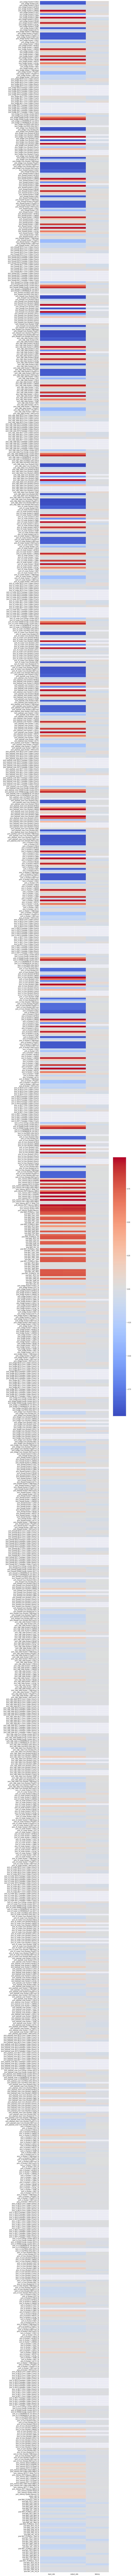

In [51]:
if DEBUG:
    corr = dataset_dt.corr()
    plt.figure(figsize=(10, 300))
    sns.heatmap(corr.iloc[3:, :3], cmap="coolwarm", annot=False, fmt=".2f")
    plt.show()

In [52]:
col = 2
if DEBUG:
    # tuple of (dataset_dt column name, correlation) in corr.iloc[, 1] if not nan
    correlation = [(i, corr.iloc[3:, col][i]) for i in dataset_dt.columns[3:] if not np.isnan(corr.iloc[3:, col][i])]
    correlation.sort(key=lambda x: (x[1]), reverse=True)
    for i in range(len(correlation)):
        print(correlation[i])

('pcm_rx Core (Socket) L3MPI', 0.09539068060720664)
('pcm_ndpi_stats Core (Socket) TEMP', 0.08342175352439038)
('pcm_nf_router Socket 0 FREQ', 0.07939692612188926)
('pcm_payload_scan Core (Socket) TEMP', 0.07920957435865437)
('pcm_tx Socket 1 TEMP', 0.07914063780835538)
('pcm_nf_router Socket 0 FREQ_dt', 0.07842894633812579)
('pcm_tx Socket 0 TEMP', 0.07758643385778724)
('pcm_tx Core (Socket) TEMP', 0.07683192651283946)
('pcm_bridge Socket 0 TEMP', 0.07586763003832966)
('pcm_payload_scan Socket 0 FREQ', 0.07472114138089185)
('pcm_payload_scan Socket 0 FREQ_dt', 0.07144258541351613)
('pcm_ndpi_stats Socket 0 TEMP', 0.06982601833379079)
('pcm_firewall Socket 1 TEMP', 0.06972620749214606)
('pcm_rx Socket 0 TEMP', 0.06914715439977924)
('pcm_bridge Socket 1 TEMP', 0.06764037962976113)
('pcm_bridge Socket 1 AFREQ', 0.06666326185522725)
('pcm_nf_router Socket 1 TEMP', 0.06616713798947212)
('pcm_firewall Core (Socket) TEMP', 0.06597357462446106)
('pcm_ndpi_stats Socket 1 TEMP', 0.0655850174548

In [53]:
dataset_dt_X = dataset_dt.iloc[1:-1, 3:]
dataset_dt_output = dataset_dt.iloc[1:-1, 1]
dataset_dt_latency = dataset_dt.iloc[1:-1, 2]


In [54]:
# sklearn.decomposition PCA analysis
scaler = StandardScaler()
scaler.fit(dataset_dt_X)
scaled_data = scaler.transform(dataset_dt_X)

In [55]:

pca = PCA(n_components=2)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

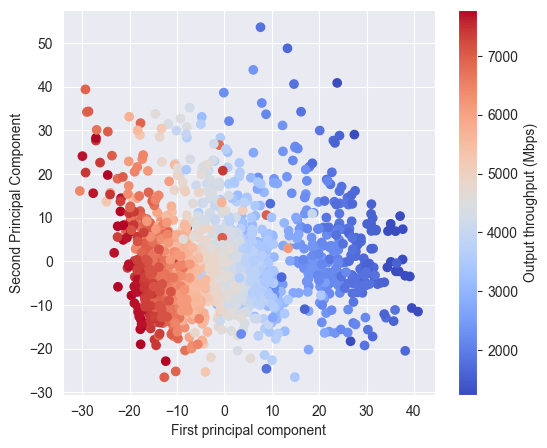

In [68]:

plt.figure(figsize=(6,5))
plt.scatter(x_pca[:,0],x_pca[:,1],c=dataset_dt_output,cmap='coolwarm')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
# add color bar
cbar = plt.colorbar()
cbar.set_label('Output throughput (Mbps)')

# plt.savefig("../figure/exp-7-pca_output_rate.pdf", format='pdf', bbox_inches='tight')


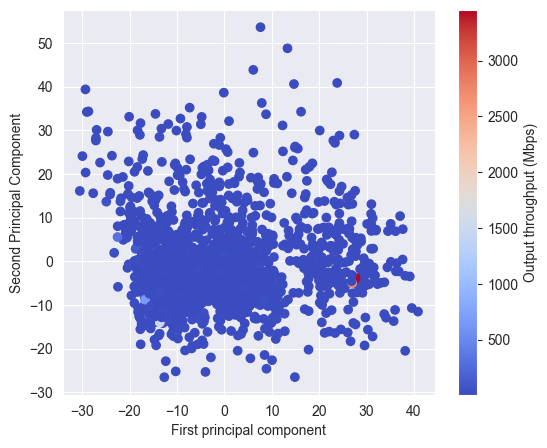

In [74]:

plt.figure(figsize=(6,5))
plt.scatter(x_pca[:,0],x_pca[:,1],c=dataset_dt_latency,cmap='coolwarm')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
# add color bar
cbar = plt.colorbar()
cbar.set_label('Output throughput (Mbps)')

# plt.savefig("../figure/exp-7-pca_latency_total.pdf", format='pdf', bbox_inches='tight')


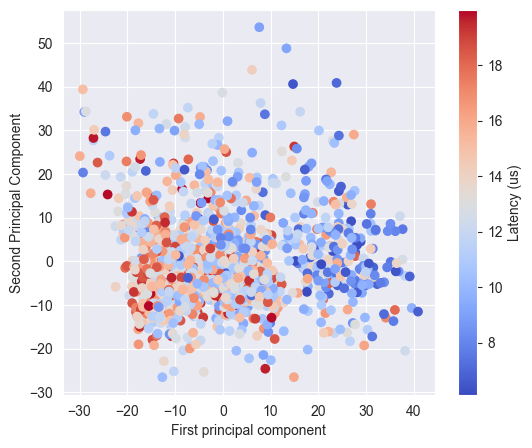

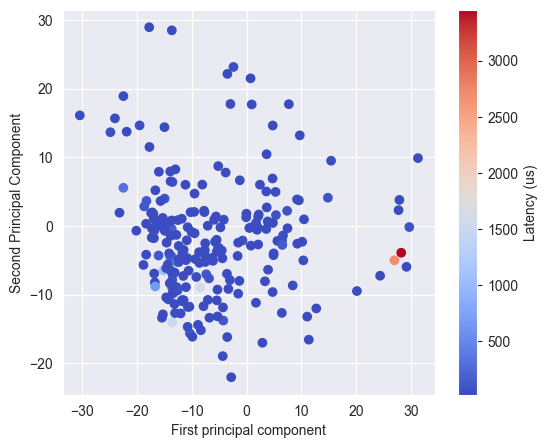

In [76]:

high_latency_threshold = 20
is_high_latency = dataset_dt_latency > high_latency_threshold
# filter x_pca
x_pca_high_latency = x_pca[is_high_latency]
x_pca_low_latency = x_pca[~is_high_latency]
y_high_latency = dataset_dt_latency[is_high_latency]
y_low_latency = dataset_dt_latency[~is_high_latency]

plt.figure(figsize=(6, 5))
plt.scatter(x_pca_low_latency[:,0],x_pca_low_latency[:,1],c=y_low_latency,cmap='coolwarm')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
# add color bar
cbar = plt.colorbar()
cbar.set_label('Latency (us)')
# plt.show()

plt.savefig("../figure/exp-7-pca_latency_low.pdf", format='pdf', bbox_inches='tight')


plt.figure(figsize=(6, 5))
plt.scatter(x_pca_high_latency[:,0],x_pca_high_latency[:,1],c=y_high_latency,cmap='coolwarm')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
# add color bar
cbar = plt.colorbar()
cbar.set_label('Latency (us)')
# plt.show()

plt.savefig("../figure/exp-7-pca_latency_high.pdf", format='pdf', bbox_inches='tight')



In [59]:

pca.components_

array([[ 0.06695671,  0.06841756,  0.00682158, ..., -0.0007767 ,
        -0.00071206,  0.00028455],
       [-0.00245849,  0.00979327, -0.00113477, ...,  0.0032963 ,
         0.00350196,  0.00244154]])

<Axes: >

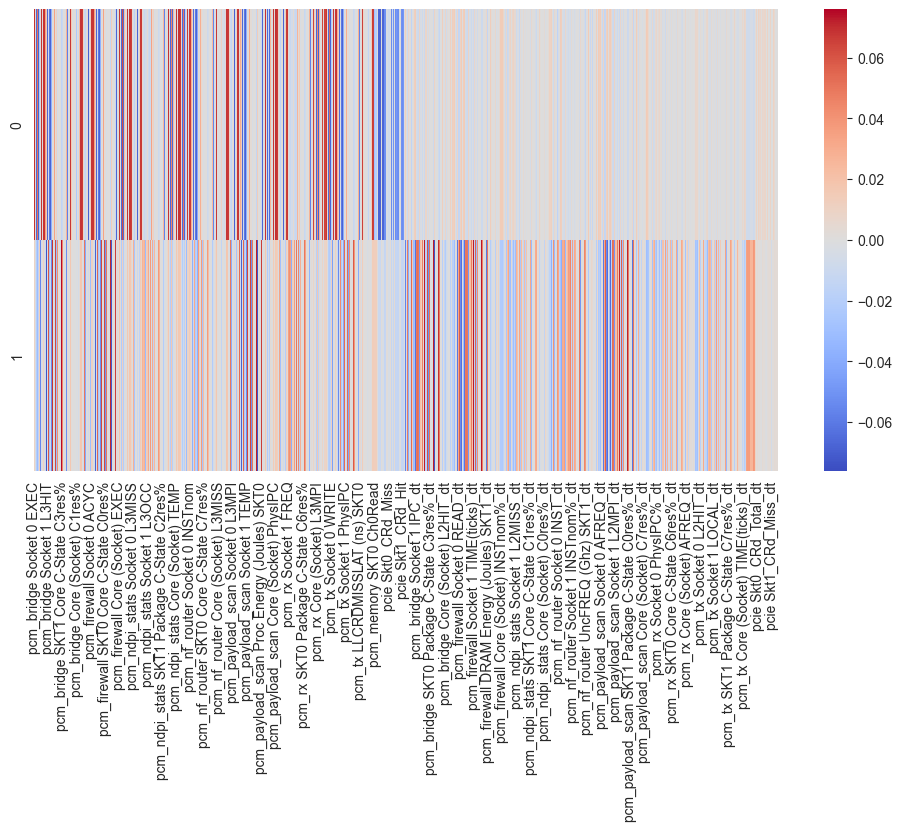

In [60]:
df_comp = pd.DataFrame(pca.components_,columns=dataset_dt_X.columns)
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='coolwarm',)


In [61]:

corr

input_rate  output_rate   latency  \
input_rate                  1.000000     0.999575  0.001031   
output_rate                 0.999575     1.000000  0.001111   
latency                     0.001031     0.001111  1.000000   
pcm_bridge Socket 0 EXEC   -0.865191    -0.866567  0.033537   
pcm_bridge Socket 0 IPC    -0.885003    -0.886178  0.000164   
...                              ...          ...       ...   
pcie Skt1_CRd_Hit_dt       -0.000980    -0.000435 -0.146357   
pcie Skt1_DRd_Hit_dt       -0.052838    -0.052958 -0.026708   
pcie Skt1_ItoM_Hit_dt      -0.002040    -0.002286 -0.000388   
pcie Skt1_PRd_Hit_dt       -0.001564    -0.001956  0.007772   
pcie Skt1_WiL_Hit_dt       -0.013519    -0.013039  0.024553   

                          pcm_bridge Socket 0 EXEC  pcm_bridge Socket 0 IPC  \
input_rate                           -8.651908e-01                -0.885003   
output_rate                          -8.665675e-01                -0.886178   
latency                               3.353653e-02                 0.000164   
pcm_bridge Socket 0 EXEC              1.000000e+00                 0.906636   
pcm_bridge Socket 0 IPC               9.066356e-01                 1.000000   
...                                            ...                      ...   
pcie Skt1_CRd_Hit_dt                 -1.522816e-02                 0.006062   
pcie Skt1_DRd_Hit_dt                  5.655612e-02                 0.059572   
pcie Skt1_ItoM_Hit_dt                 6.833934e-18                -0.008530   
pcie Skt1_PRd_Hit_dt                 -1.403198e-02                -0.013142   
pcie Skt1_WiL_Hit_dt                  1.551997e-02                -0.000985   

                          pcm_bridge Socket 0 FREQ  pcm_bridge Socket 0 AFREQ  \
input_rate                               -0.124431              -1.065804e-02   
output_rate                              -0.125559              -1.042675e-02   
latency                                   0.058909              -3.489519e-03   
pcm_bridge Socket 0 EXEC                  0.188911               2.243604e-02   
pcm_bridge Socket 0 IPC                  -0.010868               2.395630e-02   
...                                            ...                        ...   
pcie Skt1_CRd_Hit_dt                     -0.041990               9.483807e-03   
pcie Skt1_DRd_Hit_dt                      0.012283               6.151585e-02   
pcie Skt1_ItoM_Hit_dt                     0.030777              -7.734243e-16   
pcie Skt1_PRd_Hit_dt                     -0.005877              -1.446837e-02   
pcie Skt1_WiL_Hit_dt                      0.021773               2.345244e-02   

                          pcm_bridge Socket 0 L3MISS  \
input_rate                                 -0.061892   
output_rate                                -0.060189   
latency                                    -0.005002   
pcm_bridge Socket 0 EXEC                   -0.096509   
pcm_bridge Socket 0 IPC                    -0.208140   
...                                              ...   
pcie Skt1_CRd_Hit_dt                        0.008726   
pcie Skt1_DRd_Hit_dt                        0.017354   
pcie Skt1_ItoM_Hit_dt                       0.054713   
pcie Skt1_PRd_Hit_dt                        0.039637   
pcie Skt1_WiL_Hit_dt                        0.010971   

                          pcm_bridge Socket 0 L2MISS  \
input_rate                                  0.964502   
output_rate                                 0.965314   
latency                                    -0.013643   
pcm_bridge Socket 0 EXEC                   -0.876585   
pcm_bridge Socket 0 IPC                    -0.893181   
...                                              ...   
pcie Skt1_CRd_Hit_dt                        0.002417   
pcie Skt1_DRd_Hit_dt                       -0.062739   
pcie Skt1_ItoM_Hit_dt                       0.001794   
pcie Skt1_PRd_Hit_dt                       -0.001855   
pcie Skt1_WiL_Hit_dt                       -0.015000   

 